# Injector SM

In [17]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

In [1]:
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP

saveResultsQ = False

In [9]:
mi_module = importlib.import_module('machine_interfaces.injector.MI_injectorSM')
start = [0.47790413817328165, -8.851912749994681e-05, 0.00018995697875329523]
start_exp = [0.46247,-0.0044,-0.00027]
mi = mi_module.machine_interface(start_point = start ) 

SM was set successfully!


In [10]:
mi.getState()

(array([[ 4.77904138e-01, -8.85191275e-05,  1.89956979e-04]]),
 array([[-0.56908436]]))

### Create the GP model

In [4]:
# GP parameters
gp_ls = np.array([0.1,0.2,0.02]) # 'SOL1:solenoid_field_scale', 'CQ01:b1_gradient','SQ01:b1_gradient']
gp_precisionmat = np.diag(gp_ls**-2)
gp_amp = 1
gp_noise_variance = 0.01

hyperparams = {'precisionMatrix': gp_precisionmat, 'amplitude': gp_amp, 'noise_var': gp_noise_variance} 
gp = OGP(len(mi.pvs), hyperparams)

### Run the optimization

In [14]:
opt = BayesOpt(gp, mi, acq_func="UCB", start_dev_vals = mi.x, dev_ids = mi.pvs)
Obj_state_s = []

Supposed to be grabbing initial machine state...
x_init [[-0.04268586 -1.5910428   0.95935148]]
y_init [[-1.44844996]]


iteration = 9
current position: [[ 0.39922663 -0.42571439  0.9512576 ]] current objective value: [[1.84993992]]


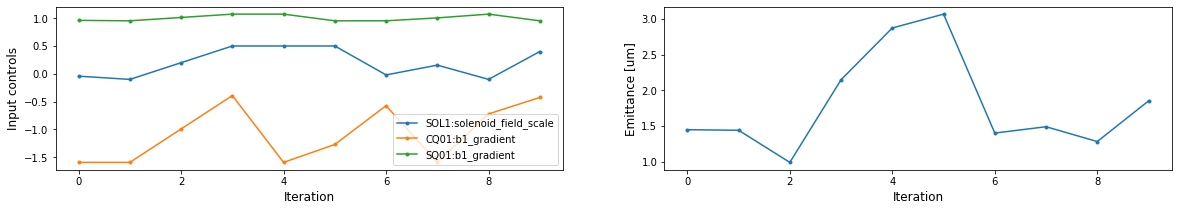

In [15]:
Niter = 10
for i in range(Niter):
    clear_output(wait=True) 
    print ('iteration =', i)
    cur_obj = -mi.getState()[1]
    print ('current position:', mi.x, 'current objective value:', cur_obj)
   
    Obj_state_s.append(cur_obj[0])
    
    f = plt.figure(figsize=(20,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax.set_ylabel('Input controls',fontsize=12)
    ax.set_xlabel('Iteration',fontsize=12)
    for x, label in zip(opt.X_obs.T, opt.dev_ids):
        ax.plot(x,'.-',label = label)
    ax.legend()
    ax2.set_ylabel('Emittance [um]',fontsize=12)
    ax2.set_xlabel('Iteration',fontsize=12)
    ax2.plot(Obj_state_s,'.-')
    plt.show(); 

    opt.OptIter()

In [12]:
#save results if desired
if saveResultsQ == True:
    timestr = datetime.now().strftime('%Y-%m-%d-%H%M%S')
    try: os.mkdir('saved_results')
    except: pass
    results = {}
    results['scan_params'] = scan_params
    results['xs'] = opt.X_obs
    results['ys'] = np.array([y[0][0] for y in opt.Y_obs])
    results['time'] = timestr
    np.save('saved_results/scan_'+timestr, results)